# Auto Regressive Linear Model

Neste notebook, vamos construir um Auto Regressive Linear Model para fazer previsões em Séries Temporais.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Começamos criando dados sintéticos para o nosso experimento:

In [2]:
N = 1000
series = np.sin(0.1*np.arange(N))

Plotamos os dados:

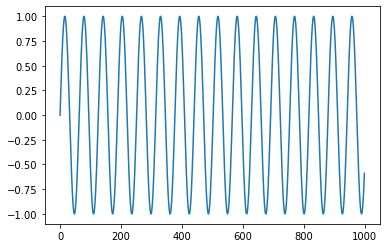

In [3]:
plt.plot(series);

A seguir construímos o conjunto de dados.

Vejamos se conseguimos usar valores T do passado para prever um pŕoximo valor.

Neste exemplo, vamos setar `T = 10`, isso significa que vamos usar os 10 últimos dados temporais para prever o próximo.

In [4]:
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10) Y.shape (990, 1)


Construímos o AutoRegressive Linear Model:

In [5]:
model = nn.Linear(T, 1)

Definimos a função Loss e o Optimizer:

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

A seguir, dividimos os dados em conjuntos de treinamento e teste:

In [7]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

Criamos uma função para encapsular o treinamento de nosso modelo:

In [8]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
            
        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

Treinamos o modelo:

In [9]:
train_losses, test_losses = full_gd(model,criterion,optimizer,X_train,y_train,X_test,y_test)

Epoch 5/200, Train Loss: 0.0450, Test Loss: 0.0798
Epoch 10/200, Train Loss: 0.0303, Test Loss: 0.0413
Epoch 15/200, Train Loss: 0.0356, Test Loss: 0.0330
Epoch 20/200, Train Loss: 0.0224, Test Loss: 0.0155
Epoch 25/200, Train Loss: 0.0092, Test Loss: 0.0041
Epoch 30/200, Train Loss: 0.0065, Test Loss: 0.0032
Epoch 35/200, Train Loss: 0.0037, Test Loss: 0.0017
Epoch 40/200, Train Loss: 0.0003, Test Loss: 0.0005
Epoch 45/200, Train Loss: 0.0006, Test Loss: 0.0014
Epoch 50/200, Train Loss: 0.0011, Test Loss: 0.0010
Epoch 55/200, Train Loss: 0.0004, Test Loss: 0.0001
Epoch 60/200, Train Loss: 0.0001, Test Loss: 0.0002
Epoch 65/200, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 70/200, Train Loss: 0.0001, Test Loss: 0.0000
Epoch 75/200, Train Loss: 0.0000, Test Loss: 0.0001
Epoch 80/200, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 85/200, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 90/200, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 95/200, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 100/200

Plotamos a loss de treinamento e teste por iteração:

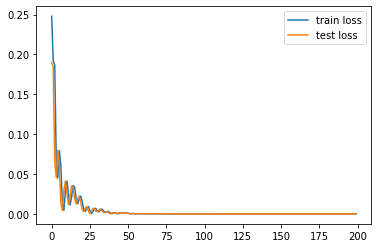

In [10]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

E então prevemos valores futuros:

In [11]:
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1, -1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

Por fim, plotamos as previsões:

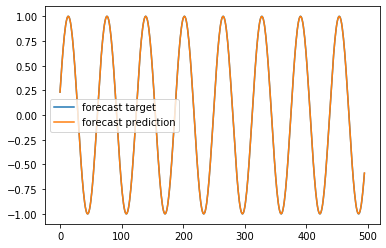

In [12]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();